In [1]:
# trabajamos sobre el fichero con el left join
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re
import ivolatility as ivol
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# ivolatility connection
apiKey = 'mCY7wK3MCDprnHUi'
ivol.setLoginParams(apiKey=apiKey)

In [2]:
df = pd.read_csv('Input/dte_problem.csv')
df['IVx'] = None

In [3]:
getMarketData = ivol.setMethod('/equities/eod/ivx')
marketData = getMarketData(symbol='FDX', date='2024-03-11')
pd.set_option('display.max_columns', None)
marketData = marketData[['record_no', 'symbol', 'exchange', 'date', 
                                  '30d IV Mean', '60d IV Mean', '90d IV Mean', 
                                  '120d IV Mean', '150d IV Mean', 
                                  '180d IV Mean', '270d IV Mean', '360d IV Mean', 
                                  '720d IV Mean', '1080d IV Mean']]
marketData

,record_no,symbol,exchange,date,30d IV Mean,60d IV Mean,90d IV Mean,120d IV Mean,150d IV Mean,180d IV Mean,270d IV Mean,360d IV Mean,720d IV Mean,1080d IV Mean
0,1,FDX,NYSE,2024-03-11,0.340419,0.288713,0.267449,0.270469,0.273344,0.272694,0.282244,0.281256,0.286649,0.286649


In [4]:
import pandas as pd
from datetime import datetime

# Define the expirations and calculate inverse square weights
expirations = {
    '30d IV Mean': 30,
    '60d IV Mean': 60,
    '90d IV Mean': 90,
    '120d IV Mean': 120,
    '150d IV Mean': 150,
    '180d IV Mean': 180,
    '270d IV Mean': 270,
    '360d IV Mean': 360,
    '720d IV Mean': 720,
    '1080d IV Mean': 1080
}

# Calculate inverse square weights and normalize them
weights = {key: 1 / value**2 for key, value in expirations.items()}
total_weight = sum(weights.values())
normalized_weights = {key: weight / total_weight for key, weight in weights.items()}

def calculate_weighted_iv(row):
    weighted_sum = 0
    total_weight = 0
    for col, weight in normalized_weights.items():
        if pd.notna(row[col]):
            weighted_sum += row[col] * weight
            total_weight += weight
    return weighted_sum / total_weight if total_weight != 0 else None

# Assuming df is your dataframe with a 'timestamp' column
# Convert the 'timestamp' column to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a new column 'IVx' in your dataframe
df['IVx'] = None

# Iterate over each unique date in the 'timestamp' column
for date in df['timestamp'].dt.date.unique():
    # Call getMarketData function for each unique date
    marketData = getMarketData(symbol='FDX', date=date.strftime('%Y-%m-%d'))
    
    # Filter the marketData dataframe to include only the required columns
    marketData = marketData[['record_no', 'symbol', 'exchange', 'date', 
                             '30d IV Mean', '60d IV Mean', '90d IV Mean', 
                             '120d IV Mean', '150d IV Mean', 
                             '180d IV Mean', '270d IV Mean', '360d IV Mean', 
                             '720d IV Mean', '1080d IV Mean']]
    
    # Calculate the weighted IV
    marketData['IVx'] = round(marketData.apply(calculate_weighted_iv, axis=1), 2)
    
    # Find the matching rows in the original dataframe and update the 'IVx' column
    matching_rows = df['timestamp'].dt.date == date
    df.loc[matching_rows, 'IVx'] = marketData['IVx'].values[0]



In [5]:
#days to expiration
def calculate_days_until(row):
    # Asegúrate de que 'timestamp' y 'optionExpirationDate' sean objetos de fecha
    timestamp_date = pd.to_datetime(row['timestamp'])
    expiration_date = pd.to_datetime(row['optionExpirationDate'])
    # Calcula la diferencia en días
    days_until = (expiration_date - timestamp_date).days
    return days_until

# Aplica la función a cada fila del DataFrame
df['dte'] = df.apply(calculate_days_until, axis=1)

In [6]:
df

,timestamp,optionExpirationDate,optionSymbol,optionStrike,optionIv,optionBidPrice,IVx,dte
0,2023-01-03 10:00:00,2023-03-17,FDX 230317P00180000,180.0,0.3608,13.35,0.34,72
1,2023-01-04 10:00:00,2023-03-17,FDX 230317P00185000,185.0,0.3524,13.10,0.33,71
2,2023-01-05 10:00:00,2023-02-24,FDX 230224P00185000,185.0,0.3101,10.35,0.33,49
3,2023-01-06 10:00:00,2023-03-17,FDX 230317P00190000,190.0,0.3426,15.30,0.31,69
4,2023-01-09 10:00:00,2023-03-17,FDX 230317P00190000,190.0,0.3383,11.30,0.31,66
...,...,...,...,...,...,...,...,...
324,2024-04-29 10:00:00,2024-06-21,FDX 240621P00270000,270.0,0.1975,9.45,0.21,52
325,2024-04-30 10:00:00,2024-06-21,FDX 240621P00270000,270.0,0.1986,11.30,0.22,51
326,2024-05-01 10:00:00,2024-06-21,FDX 240621P00270000,270.0,0.2011,12.70,0.22,50
327,2024-05-02 10:00:00,2024-06-21,FDX 240621P00270000,270.0,0.1975,11.45,0.21,49


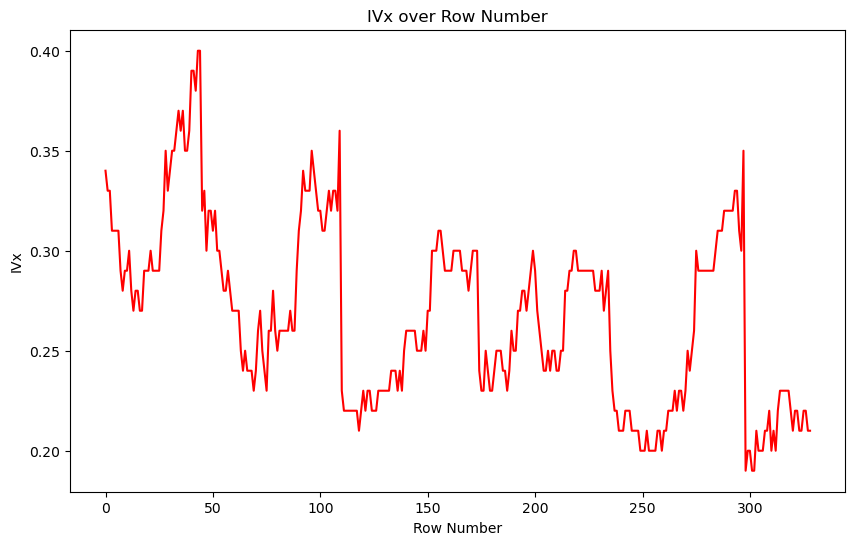

In [14]:
# Plotting the IVx values along the timeline using row numbers
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['IVx'], color='red', linestyle='-')
plt.xlabel('Row Number')
plt.ylabel('IVx')
plt.title('IVx over Row Number')
plt.grid(False)
plt.show()



In [24]:
import pandas as pd
import numpy as np

# Assuming df['IVx'] is already calculated and present in your DataFrame

# Manual calculation of Median Absolute Deviation (MAD)
def calculate_mad(series):
    median = series.median()
    deviations = np.abs(series - median)
    mad = deviations.median()
    return mad

# Normalization based on deviation from the median
def normalize_by_median(data, column_name):
    median = data[column_name].median()
    mad = calculate_mad(data[column_name])  # Manual MAD calculation

    # Apply median deviation normalization
    if mad == 0:
        data[column_name + '_M'] = 0  # Handle zero MAD
    else:
        data[column_name + '_M'] = (data[column_name] - median) / mad
    
    # Apply tanh to stretch the values horizontally across the range
    data[column_name + '_N'] = data[column_name + '_M'].apply(lambda x: 0.5 * (np.tanh(x) + 1))

    return data

# Normalize 'IVx' to 'IVx_N' using the median-based method followed by tanh adjustment
df = normalize_by_median(df, 'IVx')

# Show the new columns with normalized IVx values based on median deviation and tanh transformation
print(df[['IVx', 'IVx_M', 'IVx_N']])




      IVx     IVx_M     IVx_N
0    0.34  2.333333  0.990684
1    0.33       2.0  0.982014
2    0.33       2.0  0.982014
3    0.31  1.333333  0.935031
4    0.31  1.333333  0.935031
..    ...       ...       ...
324  0.21      -2.0  0.017986
325  0.22 -1.666667  0.034445
326  0.22 -1.666667  0.034445
327  0.21      -2.0  0.017986
328  0.21      -2.0  0.017986

[329 rows x 3 columns]


In [21]:
df

,timestamp,optionExpirationDate,optionSymbol,optionStrike,optionIv,optionBidPrice,IVx,dte,IVx_N,IVx_M
0,2023-01-03 10:00:00,2023-03-17,FDX 230317P00180000,180.0,0.3608,13.35,0.34,72,0.990684,2.333333
1,2023-01-04 10:00:00,2023-03-17,FDX 230317P00185000,185.0,0.3524,13.10,0.33,71,0.982014,2.0
2,2023-01-05 10:00:00,2023-02-24,FDX 230224P00185000,185.0,0.3101,10.35,0.33,49,0.982014,2.0
3,2023-01-06 10:00:00,2023-03-17,FDX 230317P00190000,190.0,0.3426,15.30,0.31,69,0.935031,1.333333
4,2023-01-09 10:00:00,2023-03-17,FDX 230317P00190000,190.0,0.3383,11.30,0.31,66,0.935031,1.333333
...,...,...,...,...,...,...,...,...,...,...
324,2024-04-29 10:00:00,2024-06-21,FDX 240621P00270000,270.0,0.1975,9.45,0.21,52,0.017986,-2.0
325,2024-04-30 10:00:00,2024-06-21,FDX 240621P00270000,270.0,0.1986,11.30,0.22,51,0.034445,-1.666667
326,2024-05-01 10:00:00,2024-06-21,FDX 240621P00270000,270.0,0.2011,12.70,0.22,50,0.034445,-1.666667
327,2024-05-02 10:00:00,2024-06-21,FDX 240621P00270000,270.0,0.1975,11.45,0.21,49,0.017986,-2.0


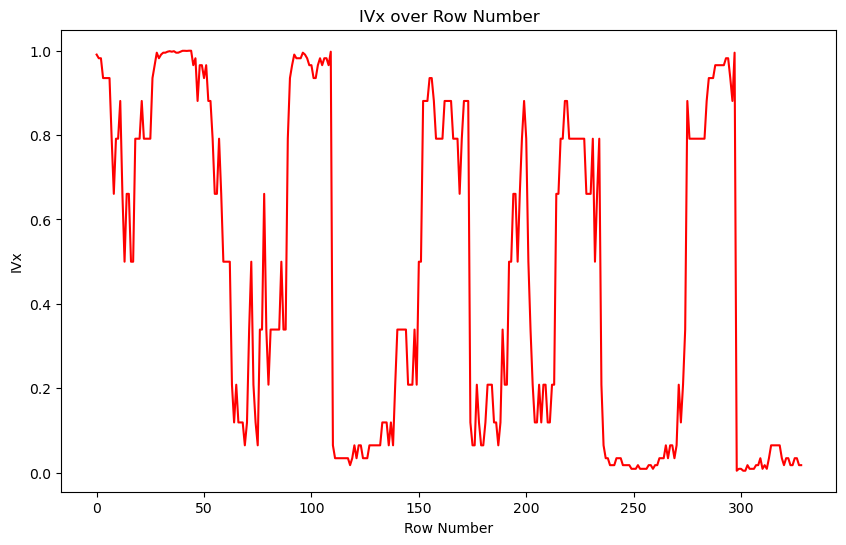

In [26]:
# Plotting the IVx values along the timeline using row numbers
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['IVx_N'], color='red', linestyle='-')
plt.xlabel('Row Number')
plt.ylabel('IVx')
plt.title('IVx over Row Number')
plt.grid(False)
plt.show()
